In [ ]:
import pandas as pd
import numpy as np
import sklearn
import scipy

# Mount google drive
from google.colab import drive
drive.mount('/content/drive')

%cd /content/drive/MyDrive/20.440_Omics/Final_Project_Raw_Counts

# Create seq df (will be gene x sample)
df = pd.read_csv('/content/drive/MyDrive/20.440_Omics/Final_Project_Raw_Counts/Counts.csv')

# Transpose the df (will be sample x gene)
transpose_df = df.transpose()

# Check if all elements of the first row are unique
are_unique = len(transpose_df.columns) == len(set(transpose_df.iloc[0]))

if are_unique:
    print("All elements of the first row are unique.")
else:
    print("Not all elements of the first row are unique.")

# Set the first row as column titles
transpose_df.columns = transpose_df.iloc[0]

# Drop the first row
transpose_df = transpose_df.drop(transpose_df.index[0])

Mounted at /content/drive
/content/drive/MyDrive/20.440_Omics/Final_Project_Raw_Counts
All elements of the first row are unique.


In [ ]:
%cd /content/drive/MyDrive/20.440_Omics/Final_Project_Pheno_Data

# Make pheno df (will be sample x phenotype)
pheno_dataset = pd.read_csv("/content/drive/MyDrive/20.440_Omics/Final_Project_Pheno_Data/phenoData.csv")

pheno_dataset = pheno_dataset.set_index(transpose_df.index)

pheno_dataset = pheno_dataset[['sample_name', 'etiology', 'race', 'disease_race']]

pheno_dataset.replace(to_replace='Caucasian_PPCM', value='Caucasian_Other', inplace=True)
pheno_dataset.replace(to_replace='AA_PPCM', value='AA_Other', inplace=True)
pheno_dataset.replace(to_replace='Caucasian_HCM', value='Caucasian_Other', inplace=True)
pheno_dataset.replace(to_replace='AA_HCM', value='AA_Other', inplace=True)

/content/drive/MyDrive/20.440_Omics/Final_Project_Pheno_Data


In [ ]:
transpose_df.head()

Unnamed: 0,ENSG00000000003,ENSG00000000005,ENSG00000000419,ENSG00000000457,ENSG00000000460,ENSG00000000938,ENSG00000000971,ENSG00000001036,ENSG00000001084,ENSG00000001167,...,ENSG00000273481,ENSG00000273483,ENSG00000273484,ENSG00000273485,ENSG00000273486,ENSG00000273487,ENSG00000273488,ENSG00000273489,ENSG00000273492,ENSG00000273493
C00039,415,2,1386,443,116,310,3050,1531,1363,811,...,0,17,0,1,62,58,4,107,61,5
C00055,542,11,1983,665,118,192,3158,2385,1622,742,...,0,9,0,6,89,46,6,38,54,4
C00074,65,1,805,187,40,1175,560,1028,879,335,...,0,6,0,3,7,1,4,59,2,2
C00085,523,17,1542,569,120,517,3392,1693,1707,530,...,0,14,0,6,73,33,3,45,10,6
C00105,345,14,940,300,57,282,2863,1442,850,404,...,0,2,0,5,44,13,2,14,13,1


In [ ]:
# Perform median-ratio

# Add 1 to all entries to prevent log(0)

transpose_df += 1

# Convert all entries to float to enable np.log()
transpose_df = transpose_df.astype(float)

# Take log() of all entries
transpose_df_log = np.log(transpose_df)

In [ ]:
# Get average value for gene
gene_means_across_samples = transpose_df_log.mean()

# Subtract average value for gene from gene for each sample
transpose_df_log_subtract_mean = transpose_df_log - gene_means_across_samples

# Get median gene expression per sample
median_gene_per_sample = transpose_df_log_subtract_mean.median(axis=1)

# Get scaling factors (e^median)
scaling_factors = np.exp(median_gene_per_sample)

# Normalize each samples non-log counts by scaling factor for said sample
normalized_df = transpose_df.div(scaling_factors, axis=0)

In [ ]:
!pip install umap-learn

In [ ]:
import umap

# Initialize UMAP with desired parameters
reducer = umap.UMAP(n_neighbors=6, n_components=2, metric='euclidean')

# Fit and transform the data (assuming `df_normalized` is a DataFrame or array with your preprocessed data)
embedding = reducer.fit_transform(normalized_df)

# Create a DataFrame for the embedding to facilitate plotting
embedding_df = pd.DataFrame(embedding, columns=['UMAP1', 'UMAP2'])

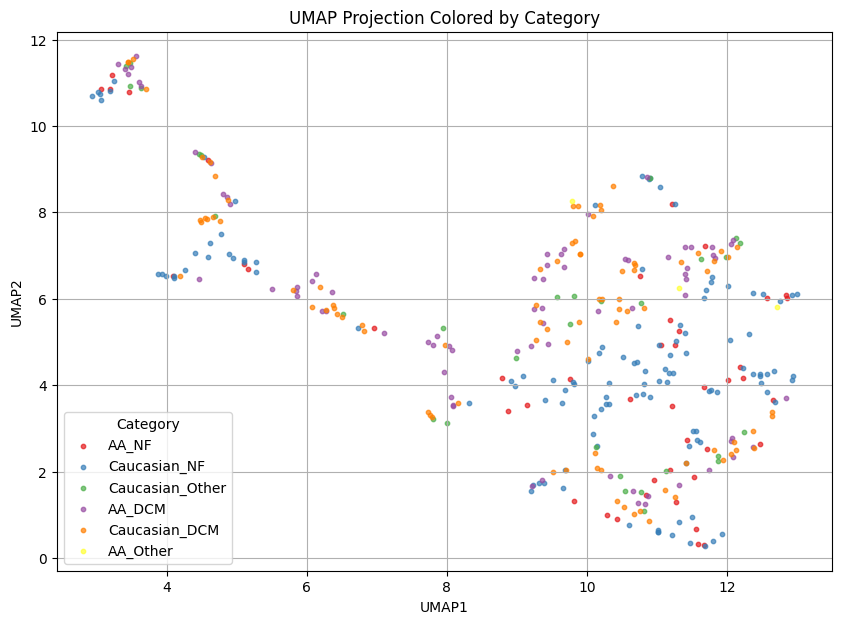

In [ ]:
import matplotlib.pyplot as plt

pheno_dataset_all = pheno_dataset.copy()

pheno_dataset_all.reset_index(drop=True, inplace=True)

embedding_df['Category'] = pheno_dataset_all['disease_race']

# Define a color palette with 6 distinct colors
colors = plt.get_cmap('Set1')  # 'Set1' is good for distinct categorical colors

# Plot each category with a different color
plt.figure(figsize=(10, 7))
categories = embedding_df['Category'].unique()
for i, category in enumerate(categories):
    # Select data belonging to the current category
    subset = embedding_df[embedding_df['Category'] == category]
    plt.scatter(subset['UMAP1'], subset['UMAP2'], color=colors(i), label=category, alpha=0.7, s=10)

# Add labels and title for clarity
plt.xlabel('UMAP1')
plt.ylabel('UMAP2')
plt.title('UMAP Projection Colored by Category')
plt.legend(title='Category')
plt.grid(True)

# Show the plot
plt.show()

In [ ]:
# Initialize an empty list to store non DCM samples
non_DCMsamples = []

# Iterate over the DataFrame
for index, row in pheno_dataset.iterrows():
    # Check if the etiology is not DCM
    if row['etiology'] in ["PPCM", "HCM", "NF"]:
        # Append the sample name to the non_DCM_samples list
        non_DCMsamples.append(row['sample_name'])

In [ ]:
# Make df for non_DCMsamples RNA seq
non_DCMsamples_normalized_df = normalized_df.copy()

# Iterate over the index of non_DCMsamples_normalized_df
for index in non_DCMsamples_normalized_df.index:
    # Check if the index is in non_DCMsamples list
    if index in non_DCMsamples:
        # Drop the row from non_DCMsamples_normalized_df
        non_DCMsamples_normalized_df.drop(index, inplace=True)

In [ ]:
# Make df for non_DCMsamples pheno
pheno_dataset_DCM = pheno_dataset.copy()

# Iterate over the index of pheno_dataset_DCM
for index in pheno_dataset_DCM.index:
    # Check if the index is in non_DCMsamples list
    if index in non_DCMsamples:
        # Drop the row from non_DCMsamples pheno
        pheno_dataset_DCM.drop(index, inplace=True)

# Initialize UMAP with desired parameters
reducer2 = umap.UMAP(n_neighbors=6, n_components=2, metric='euclidean')

# Fit and transform the data (assuming `df_normalized` is a DataFrame or array with your preprocessed data)
embedding2 = reducer2.fit_transform(non_DCMsamples_normalized_df)

# Create a DataFrame for the embedding to facilitate plotting
embedding_df2 = pd.DataFrame(embedding2, columns=['UMAP1', 'UMAP2'])

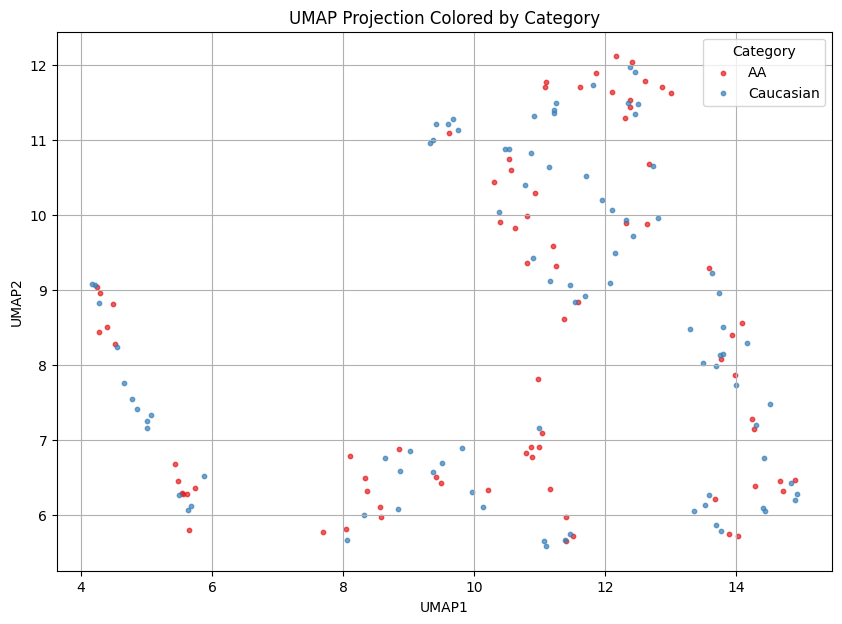

In [ ]:
import matplotlib.pyplot as plt

pheno_dataset_DCM.reset_index(drop=True, inplace=True)

embedding_df2['Category'] = pheno_dataset_DCM['race']

# Define a color palette with 6 distinct colors
colors = plt.get_cmap('Set1')  # 'Set1' is good for distinct categorical colors

# Plot each category with a different color
plt.figure(figsize=(10, 7))
categories2 = embedding_df2['Category'].unique()
for i, category in enumerate(categories2):
    # Select data belonging to the current category
    subset = embedding_df2[embedding_df2['Category'] == category]
    plt.scatter(subset['UMAP1'], subset['UMAP2'], color=colors(i), label=category, alpha=0.7, s=10)

# Add labels and title
plt.xlabel('UMAP1')
plt.ylabel('UMAP2')
plt.title('UMAP Projection Colored by Category')
plt.legend(title='Category')
plt.grid(True)

# Show the plot
plt.show()

In [ ]:
import pandas as pd
import numpy as np
from scipy.stats import rankdata

def quantile_normalize_using_scipy(df):
    # Convert DataFrame to numpy array
    arr = df.values
    # Get ranks of the values along each column
    ranks = np.apply_along_axis(rankdata, 0, arr)
    # Compute the average of ranks across rows
    rank_means = np.mean(arr[np.argsort(ranks, axis=0), np.arange(ranks.shape[1])], axis=1)
    # Assign average of ranks to the ranks and then revert the sorting
    normalized_array = np.apply_along_axis(lambda r: np.sort(rank_means)[r-1], 0, ranks.astype(int)-1)
    # Convert numpy array back to DataFrame
    return pd.DataFrame(normalized_array, index=df.index, columns=df.columns)

quantile_normalize_transpose_df = quantile_normalize_using_scipy(transpose_df)

In [ ]:
# Add 1 to all entries to prevent log(0)
quantile_normalize_transpose_df += 1

# Convert all entries to float to enable np.log()
quantile_normalize_transpose_df = quantile_normalize_transpose_df.astype(float)

# Take log() of all entries
quantile_normalize_transpose_df_log = np.log(quantile_normalize_transpose_df)

In [ ]:
# Get average value for gene for all samples
gene_means_across_samples2 = quantile_normalize_transpose_df_log.mean()

# Subtract average value for gene from gene for each sample
quantile_normalize_transpose_df_log_subtract_mean = quantile_normalize_transpose_df_log - gene_means_across_samples2

# Get median gene expression per sample
median_gene_per_sample2 = quantile_normalize_transpose_df_log_subtract_mean.median(axis=1)

# Get scaling factors
scaling_factors2 = np.exp(median_gene_per_sample2)

# Normalize by genes of a sample by samples scaling factor.
normalized_df2 = quantile_normalize_transpose_df.div(scaling_factors, axis=0)

In [ ]:
# Initialize UMAP with desired parameters
reducer3 = umap.UMAP(n_neighbors=6, n_components=2, metric='euclidean')

# Fit and transform the data (assuming `df_normalized` is a DataFrame or array with your preprocessed data)
embedding3 = reducer3.fit_transform(normalized_df2)

# Create a DataFrame for the embedding to facilitate plotting
embedding_df3 = pd.DataFrame(embedding3, columns=['UMAP1', 'UMAP2'])

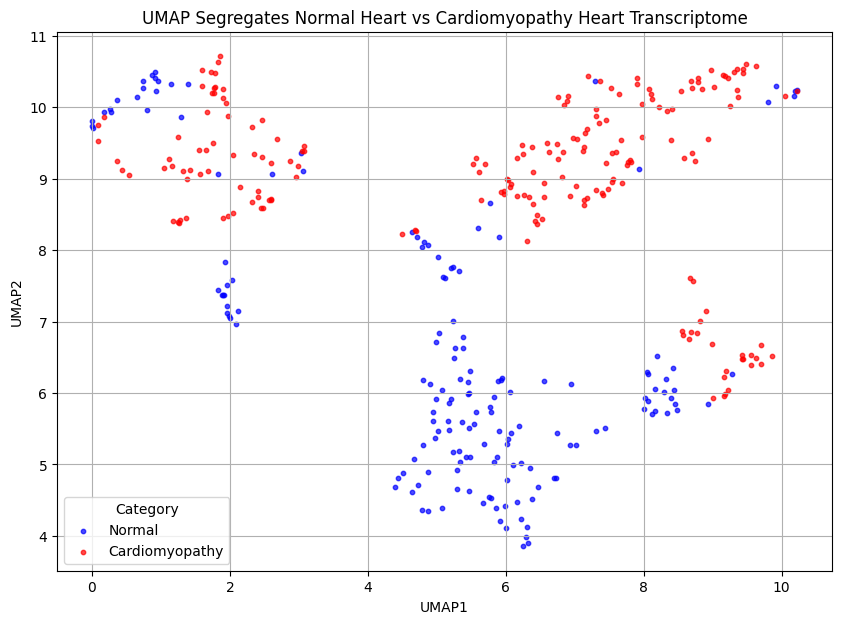

In [ ]:
pheno_dataset_all_copy = pheno_dataset_all.copy()

pheno_dataset_all_copy.replace(to_replace='Caucasian_Other', value='Cardiomyopathy', inplace=True)
pheno_dataset_all_copy.replace(to_replace='AA_Other', value='Cardiomyopathy', inplace=True)
pheno_dataset_all_copy.replace(to_replace='Caucasian_DCM', value='Cardiomyopathy', inplace=True)
pheno_dataset_all_copy.replace(to_replace='AA_DCM', value='Cardiomyopathy', inplace=True)
pheno_dataset_all_copy.replace(to_replace='Caucasian_NF', value='Normal', inplace=True)
pheno_dataset_all_copy.replace(to_replace='AA_NF', value='Normal', inplace=True)


embedding_df3['Category'] = pheno_dataset_all_copy['disease_race']

# Define color list
colors = ['blue', 'red']

# Plot each category with a different color
plt.figure(figsize=(10, 7))
categories = embedding_df3['Category'].unique()
for i, category in enumerate(categories):
    # Select data belonging to the current category
    subset = embedding_df3[embedding_df3['Category'] == category]
    # Use the color list with square brackets to pick the color by index
    plt.scatter(subset['UMAP1'], subset['UMAP2'], color=colors[i % len(colors)], label=category, alpha=0.7, s=10)

# Add labels and title
plt.xlabel('UMAP1')
plt.ylabel('UMAP2')
plt.title('UMAP Segregates Normal Heart vs Cardiomyopathy Heart Transcriptome')
plt.legend(title='Category')
plt.grid(True)

file_path = '/content/drive/My Drive/UMAP_Segregates_Normal_Heart_vs_Cardiomyopathy_Heart_Transcriptome'

# Save the plot
plt.savefig(file_path, format='png')

# Show the plot
plt.show()

In [ ]:
# Make df for non_DCMsamples RNA seq
non_DCMsamples_transpose_df = transpose_df.copy()

# Iterate over the index of non_AA_DCMsamples_transpose_df
for index in non_DCMsamples_transpose_df.index:
    # Check if the index is in non_DCMsamples list
    if index in non_DCMsamples:
        # Drop the row from non_DCMsamples_transpose_df
        non_DCMsamples_transpose_df.drop(index, inplace=True)

In [ ]:
non_DCM_quantile_normalize_transpose_df = quantile_normalize_using_scipy(non_DCMsamples_transpose_df)

In [ ]:
# Add 1 to all entries to prevent log(0)
non_DCM_quantile_normalize_transpose_df += 1

# Convert all entries to float to enable np.log()
non_DCM_quantile_normalize_transpose_df = non_DCM_quantile_normalize_transpose_df.astype(float)

# Take log() of all entries
non_DCM_quantile_normalize_transpose_df_log = np.log(non_DCM_quantile_normalize_transpose_df)

In [ ]:
# Get average value for gene for all samples
gene_means_across_samples3 = non_DCM_quantile_normalize_transpose_df_log.mean()

# Subtract average value for gene from gene for all samples
non_DCM_quantile_normalize_transpose_df_log_subtract_mean = non_DCM_quantile_normalize_transpose_df_log - gene_means_across_samples3

# Get median gene expression per sample
median_gene_per_sample3 = non_DCM_quantile_normalize_transpose_df_log_subtract_mean.median(axis=1)

# Get scaling factors
scaling_factors3 = np.exp(median_gene_per_sample3)

# Normalize by genes of a sample by samples scaling factor.
normalized_df3 = non_DCM_quantile_normalize_transpose_df.div(scaling_factors3, axis=0)

In [ ]:
# Initialize UMAP with desired parameters
reducer4 = umap.UMAP(n_neighbors=6, n_components=2, metric='euclidean')

# Fit and transform the data (assuming `df_normalized` is a DataFrame or array with your preprocessed data)
embedding4 = reducer4.fit_transform(normalized_df3)

# Create a DataFrame for the embedding to facilitate plotting
embedding_df4 = pd.DataFrame(embedding4, columns=['UMAP1', 'UMAP2'])

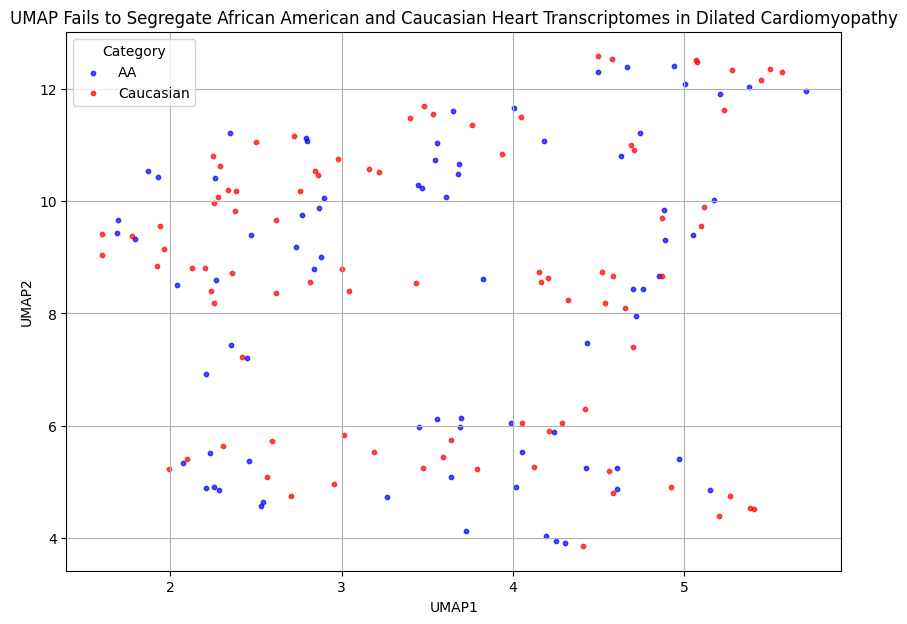

In [ ]:
import matplotlib.pyplot as plt

embedding_df4['Category'] = pheno_dataset_DCM['race']

# Define a color palette with 6 distinct colors
# colors = plt.get_cmap('Set1')  # 'Set1' is good for distinct categorical colors
colors = ['blue', 'red']

# Plot each category with a different color
plt.figure(figsize=(10, 7))
categories2 = embedding_df4['Category'].unique()
for i, category in enumerate(categories2):
    # Select data belonging to the current category
    subset = embedding_df4[embedding_df4['Category'] == category]
    plt.scatter(subset['UMAP1'], subset['UMAP2'], color=colors[i % len(colors)], label=category, alpha=0.7, s=10)

# Add labels and title for clarity
plt.xlabel('UMAP1')
plt.ylabel('UMAP2')
plt.title('UMAP Fails to Segregate African American and Caucasian Heart Transcriptomes in Dilated Cardiomyopathy')
plt.legend(title='Category')
plt.grid(True)

file_path = '/content/drive/My Drive/UMAP Fails to Segregate African American and Caucasian Heart Transcriptomes in Dilated Cardiomyopathy'


# Save the plot
plt.savefig(file_path, format='png')

# Show the plot
plt.show()